# Importation des bibliothèques

In [1]:
#Importation des bibiliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as  plt
import optuna

import random
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report,ConfusionMatrixDisplay,log_loss
import lightgbm as lgb
import shap
import plotly.graph_objects as go

/Users/issameabdeljalil/Desktop/M2_MOSEF/Scoring/Ma_Partie_Scoring/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Importation des bases de données et création de train/test

In [2]:
path_raw='data/hmeq.csv'
data_score_raw= pd.read_csv(path_raw)

In [3]:
data_train= pd.read_csv('data/data_train.csv')
data_test= pd.read_csv('data/data_test.csv')
# Train, test, split sur les données brutes
data_train_raw, data_test_raw = train_test_split(data_score_raw,
                                                 test_size=0.3,random_state=99,stratify=data_score_raw['BAD'])

In [4]:
data_train.columns

Index(['BAD', 'LOAN', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ',
       'CLNO', 'DEBTINC', 'JOB_Office', 'JOB_Other', 'JOB_ProfExe',
       'JOB_Sales', 'JOB_Self', 'REASON_HomeImp'],
      dtype='object')

In [5]:
data_test.columns

Index(['BAD', 'LOAN', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ',
       'CLNO', 'DEBTINC', 'JOB_Office', 'JOB_Other', 'JOB_ProfExe',
       'JOB_Sales', 'JOB_Self', 'REASON_HomeImp'],
      dtype='object')

In [6]:
data_score_raw.columns

Index(['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG',
       'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC'],
      dtype='object')

In [7]:
# Afin de tester les performances d'un LightGBM, nous allons le lancer sur
# différentes données : les données corrigées issues de l'EDA (modèle LightGBM simple) et les données brutes


y_test = data_test['BAD']
y_train = data_train['BAD']


## Train Modèle Simple
x_train_med = data_train[['LOAN', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ',
       'CLNO', 'DEBTINC', 'JOB_Office', 'JOB_Other', 'JOB_ProfExe',
       'JOB_Sales', 'JOB_Self', 'REASON_HomeImp']]

## Test Modèle Simple
x_test_med = data_test[['LOAN', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ',
       'CLNO', 'DEBTINC', 'JOB_Office', 'JOB_Other', 'JOB_ProfExe',
       'JOB_Sales', 'JOB_Self', 'REASON_HomeImp']]

# Train Modèle données brutes
x_train_raw = data_train_raw[['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE',
     'NINQ', 'CLNO', 'DEBTINC']]
y_train_raw = data_train_raw['BAD']


# Test Modèle Données brutes
x_test_raw = data_test_raw[['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE',
     'NINQ', 'CLNO', 'DEBTINC']]
y_test_raw = data_test_raw['BAD']


# Pour lancer LightGBM, il est nécessaire d'utiliser la fonction DataSet de Lightgbm.

data_lgb_train_med = lgb.Dataset(data=x_train_med,label=y_train)
data_lgb_test_med = lgb.Dataset(data=x_test_med,label=y_test)

data_lgb_train_raw = lgb.Dataset(data=x_train_raw,label=y_train_raw)
data_lgb_test_raw = lgb.Dataset(data=x_test_raw,label=y_test_raw)

# Modèles simples LightGBM (médiane et données brutes)

In [8]:
# On commence par faire un modèle simple sur les données corrigées grâce à l'EDA
params = {
            'objective':'binary', # On veut prédire une valeur binaire car on est dans un cas de classification binaire
            'metric': 'auc',
            'is_unbalance':'true', #On sait que nos données sont déséquilibrées entre 0 et 1, on utilise donc ce paramètre
            'boosting':'gbdt', # Gradient Boosting Decision Tree
            'num_leaves':64, #C'est la valeur par défaut
            'feature_fraction':0.5,# on sélectionne la moitié des variables, réduit l'overfitting
            'bagging_fraction':0.5,#Fraction d'échantillonnage
            'bagging_freq':20, #Fréquence du bagging
            'learning_rate': 0.01,
            'verbose':-1
        }

# Train
lgb_clf_med = lgb.train(params, data_lgb_train_med, valid_sets=data_lgb_test_med, num_boost_round=2000, callbacks=[
    lgb.early_stopping(stopping_rounds=50),
    ])
lgb_clf_raw = lgb.train(params, data_lgb_train_raw, valid_sets=data_lgb_test_raw, num_boost_round=2000, callbacks=[
    lgb.early_stopping(stopping_rounds=50),
    ])

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[171]	valid_0's auc: 0.924315
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1178]	valid_0's auc: 0.953722


In [9]:
# La fonction predict nous donne la probabilité de chaque individus d'appartenir à la classe 1
y_pred_med_probs = lgb_clf_med.predict(x_test_med)

# On arrondit les résultats afin d'avoir soit 0 soit 1
y_pred_med = [round(p) for p in y_pred_med_probs]

#On fait la même chose pour la base de données brutes
y_pred_raw_probs = lgb_clf_raw.predict(x_test_raw)
y_pred_raw = [round(p) for p in y_pred_raw_probs]

print("Score d'Accuracy pour le modèle LightGBM simple : {0:0.4f}". format(accuracy_score(y_test, y_pred_med)))
print("Score d'Accuracy pour le modèle LightGBM sur données brutes: {0:0.4f}". format(accuracy_score(y_test_raw, y_pred_raw)))

Score d'Accuracy pour le modèle LightGBM simple : 0.8893
Score d'Accuracy pour le modèle LightGBM sur données brutes: 0.9239


In [10]:
results = [y_pred_med, y_pred_raw]
prediction_type = ['LightGBM Simple', 'LightGBM sur Données Brutes']
for i, pred_type in enumerate(results):
    cr = classification_report(y_test, pred_type)
    print(f"\nTableau des métriques pour le modèle {prediction_type[i]} \n \n : {cr}")


Tableau des métriques pour le modèle LightGBM Simple 
 
 :               precision    recall  f1-score   support

           0       0.93      0.93      0.93      1431
           1       0.73      0.71      0.72       357

    accuracy                           0.89      1788
   macro avg       0.83      0.82      0.82      1788
weighted avg       0.89      0.89      0.89      1788


Tableau des métriques pour le modèle LightGBM sur Données Brutes 
 
 :               precision    recall  f1-score   support

           0       0.94      0.96      0.95      1431
           1       0.84      0.77      0.80       357

    accuracy                           0.92      1788
   macro avg       0.89      0.87      0.88      1788
weighted avg       0.92      0.92      0.92      1788



In [11]:
ns_probs = [0 for _ in range(len(y_test))]

# AUC
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc_med = roc_auc_score(y_test, y_pred_med_probs)
lr_auc_raw = roc_auc_score(y_test_raw, y_pred_raw_probs)

print('Modèle Naïf: ROC AUC=%.3f' % (ns_auc))
print('LightGBM | Modèle Simple: ROC AUC=%.3f' % (lr_auc_med))
print('LightGBM | Modèle Données Brutes : ROC AUC=%.3f' % (lr_auc_raw))

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr_med, lr_tpr_med, _ = roc_curve(y_test, y_pred_med_probs)
lr_fpr_raw, lr_tpr_raw, _ = roc_curve(y_test_raw, y_pred_raw_probs)

fig = go.Figure()

fig.add_trace(go.Scatter(x=ns_fpr, y=ns_tpr, mode='lines',
                         name='Modèle Naïf',
                         line=dict(dash='dash', color='blue')))

fig.add_trace(go.Scatter(x=lr_fpr_med, y=lr_tpr_med, mode='lines+markers',
                         name='LightGBM | Modèle Simple',
                         marker=dict(symbol='circle', color='green')))

fig.add_trace(go.Scatter(x=lr_fpr_raw, y=lr_tpr_raw, mode='lines+markers',
                         name='LightGBM | Modèle Données Brutes',
                         marker=dict(symbol='circle', color='violet')))

fig.update_layout(
    title="Courbe ROC",
    xaxis_title="Taux de Faux Positifs (FPR)",
    yaxis_title="Taux de Vrais Positifs (TPR)",
    legend_title="Modèles",
    template="plotly_white"
)
fig.show()

Modèle Naïf: ROC AUC=0.500
LightGBM | Modèle Simple: ROC AUC=0.924
LightGBM | Modèle Données Brutes : ROC AUC=0.954


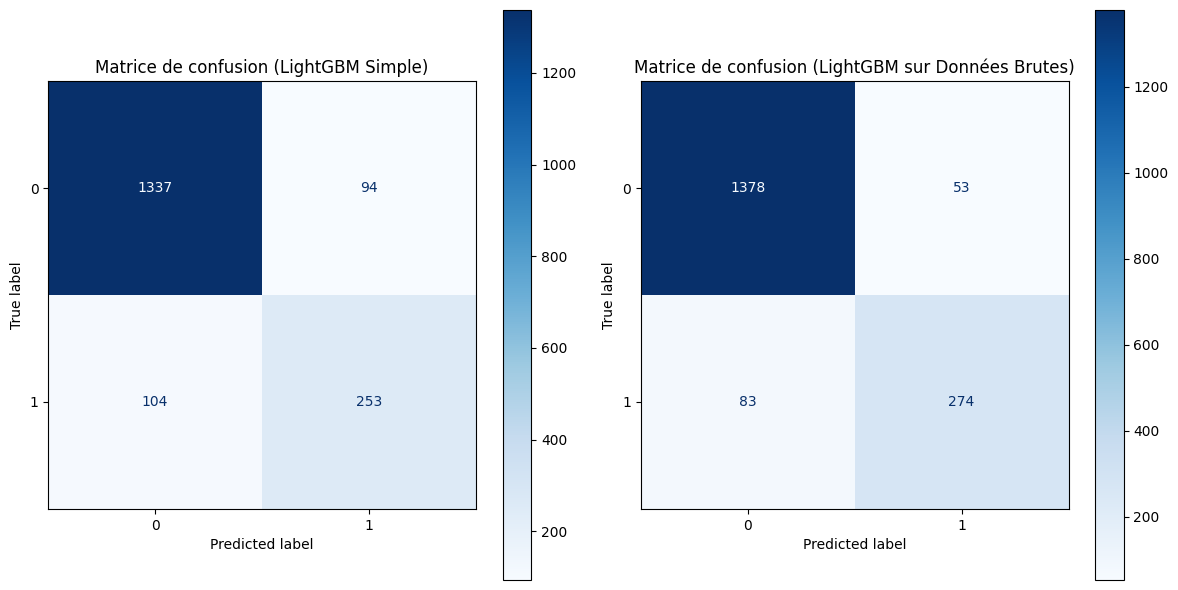

In [12]:
# Matrice de confusion pour le modèle avec médiane
cm_med = confusion_matrix(y_test, y_pred_med)
disp_med = ConfusionMatrixDisplay(confusion_matrix=cm_med)

# Matrice de confusion pour le modèle avec données brutes
cm_raw = confusion_matrix(y_test, y_pred_raw)
disp_raw = ConfusionMatrixDisplay(confusion_matrix=cm_raw)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

disp_med.plot(ax=axes[0], cmap='Blues')
axes[0].set_title("Matrice de confusion (LightGBM Simple)")

disp_raw.plot(ax=axes[1], cmap='Blues')
axes[1].set_title("Matrice de confusion (LightGBM sur Données Brutes)")

plt.tight_layout()
plt.show()

In [13]:
# Log-loss données test
logloss_test_med = log_loss(y_test, y_pred_med_probs)
logloss_test_raw = log_loss(y_test_raw, y_pred_raw_probs)

# Log-loss données train
y_train_med_probs = lgb_clf_med.predict(x_train_med)
y_train_raw_probs = lgb_clf_raw.predict(x_train_raw)

logloss_train_med = log_loss(y_train, y_train_med_probs)
logloss_train_raw = log_loss(y_train_raw, y_train_raw_probs)

print(f"Log-Loss (Train) pour le modèle LightGBM sur Données Brutes : {logloss_train_raw:.4f}")
print(f"Log-Loss (Test) pour le modèle LightGBM sur Données Brutes : {logloss_test_raw:.4f}")

print(f"Log-Loss (Train) pour le modèle LightGBM Simple : {logloss_train_med:.4f}")
print(f"Log-Loss (Test) pour le modèle LightGBM Simple : {logloss_test_med:.4f}")

Log-Loss (Train) pour le modèle LightGBM sur Données Brutes : 0.0305
Log-Loss (Test) pour le modèle LightGBM sur Données Brutes : 0.2043
Log-Loss (Train) pour le modèle LightGBM Simple : 0.2660
Log-Loss (Test) pour le modèle LightGBM Simple : 0.3204


# Optimisation du modèle simple en menant un LightGBM à l'aide d'Optuna

* On va maintenant optimiser les hyperparamètres du modèle avec médiane pour pouvoir obtenir les meilleurs résultats possibles.
Pour cela on utilise Optuna


In [15]:
def objective(trial):
    # Optimisation des paramètres
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'is_unbalance': 'true',
        'boosting': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),  # Optimisation de num_leaves
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),  # Optimisation de feature_fraction
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),  # Optimisation de bagging_fraction
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 50),  # Optimisation de bagging_freq
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),# Optimisation du learning rate
        'verbose': 0
    }

    # Validation croisée 
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    auc_scores = []
    for train_idx, valid_idx in skf.split(x_train_med, y_train):
        X_train, X_valid = x_train_med.iloc[train_idx], x_train_med.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        dtrain = lgb.Dataset(X_train, label=y_train_fold)
        dvalid = lgb.Dataset(X_valid, label=y_valid_fold, reference=dtrain)

        # Train
        lgb_clf_med = lgb.train(params, dtrain, valid_sets=[dvalid], num_boost_round=2000, callbacks=[
            lgb.early_stopping(stopping_rounds=50),
        ])

        # Prédictions sur le jeu de validation
        y_pred_med_probs = lgb_clf_med.predict(X_valid, num_iteration=lgb_clf_med.best_iteration)

        # AUC
        auc = roc_auc_score(y_valid_fold, y_pred_med_probs)
        auc_scores.append(auc)

    # Moyenne des AUC pour tous nos splits de StratifiedKfold
    return np.mean(auc_scores)




In [16]:
# Optimisation avec Optuna
optuna.logging.disable_default_handler()
study_opti = optuna.create_study(direction='maximize')
study_opti.optimize(objective, n_trials=100)
study_opti.best_params

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[80]	valid_0's auc: 0.917127
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	valid_0's auc: 0.945477
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[186]	valid_0's auc: 0.931814
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	valid_0's auc: 0.922372
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[86]	valid_0's auc: 0.923427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

{'num_leaves': 83,
 'feature_fraction': 0.7467168052229426,
 'bagging_fraction': 0.7250842562696895,
 'bagging_freq': 45,
 'learning_rate': 0.0442986497272954}

In [17]:
best_params=study_opti.best_params

best_params

{'num_leaves': 83,
 'feature_fraction': 0.7467168052229426,
 'bagging_fraction': 0.7250842562696895,
 'bagging_freq': 45,
 'learning_rate': 0.0442986497272954}

In [18]:
fixed_params = {
    'objective': 'binary',  # On veut prédire une valeur binaire
    'is_unbalance': 'true',  # Gérer les classes déséquilibrées
    'boosting': 'gbdt',  
}

final_params = {**best_params, **fixed_params}
final_params

{'num_leaves': 83,
 'feature_fraction': 0.7467168052229426,
 'bagging_fraction': 0.7250842562696895,
 'bagging_freq': 45,
 'learning_rate': 0.0442986497272954,
 'objective': 'binary',
 'is_unbalance': 'true',
 'boosting': 'gbdt'}

In [50]:
optuna.visualization.plot_optimization_history(study_opti) #On voit que plus on augmente le nombre de trial, meilleure sera la valeur de l'AUC. Cela reste marginal après le trial 52.

In [20]:
optuna.visualization.plot_param_importances(study_opti)

In [21]:
########### LightGBM optimisé ###########

dtrain_final = lgb.Dataset(data=x_train_med, label=y_train) #on n'utilise plus de données d'entraînement stratifiées maintenant on utilise toutes celles à notre disposition donc y_train

dvalid_final= lgb.Dataset(data=x_test_med, label=y_test) # On utilise toutes les données donc y_test et non pas les y_valid_fold.

# Train
lgb_clf_final = lgb.train(final_params, dtrain_final, valid_sets=[dvalid_final], num_boost_round=2000, callbacks=[
    lgb.early_stopping(stopping_rounds=50),
])

# Prédictions 
y_pred_final_probs = lgb_clf_final.predict(x_test_med, num_iteration=lgb_clf_final.best_iteration)



Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[175]	valid_0's binary_logloss: 0.225933


In [22]:
########### Courbe ROC LightGBM optimisé ###########

ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc_med = roc_auc_score(y_test, y_pred_med_probs)
lr_auc_opti_med = roc_auc_score(y_test, y_pred_final_probs)

print('Modèle Naïf: ROC AUC=%.3f' % (ns_auc))
print('LightGBM | Modèle sur Données Brutes: ROC AUC=%.3f' % (lr_auc_raw))
print('LightGBM | Modèle Simple: ROC AUC=%.3f' % (lr_auc_med))
print('LightGBM | Modèle optimisé: ROC AUC=%.3f' % (lr_auc_opti_med))
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr_med, lr_tpr_med, _ = roc_curve(y_test, y_pred_med_probs)
lr_fpr_opti_med, lr_tpr_opti_med, thresholds = roc_curve(y_test, y_pred_final_probs)

# On calcule le seuil optimal
tpr_fpr_diff = lr_tpr_opti_med - lr_fpr_opti_med
best_idx = np.argmax(tpr_fpr_diff)
best_threshold_opti = thresholds[best_idx]
best_tpr = lr_tpr_opti_med[best_idx]
best_fpr = lr_fpr_opti_med[best_idx]

fig = go.Figure()
fig.add_trace(go.Scatter(x=ns_fpr, y=ns_tpr, mode='lines',
                         name='Modèle Naïf',
                         line=dict(dash='dash', color='blue')))
fig.add_trace(go.Scatter(x=lr_fpr_raw, y=lr_tpr_raw, mode='lines+markers',
                         name='LightGBM | Modèle Données Brutes',
                         marker=dict(symbol='circle', color='pink')))
fig.add_trace(go.Scatter(x=lr_fpr_med, y=lr_tpr_med, mode='lines+markers',
                         name='LightGBM | Modèle Simple',
                         marker=dict(symbol='circle', color='green')))
fig.add_trace(go.Scatter(x=lr_fpr_opti_med, y=lr_tpr_opti_med, mode='lines+markers',
                         name='LightGBM | Modèle Optimisé',
                         marker=dict(symbol='circle', color='purple')))

# Seuil Optimal
fig.add_trace(go.Scatter(
    x=[best_fpr],
    y=[best_tpr],
    mode='markers',
    name=f'Seuil optimal : {best_threshold_opti:.2f}', 
    marker=dict(color='red', size=10)
))
fig.update_layout(
    title="Courbe ROC",
    xaxis_title="Taux de Faux Positifs (FPR)",
    yaxis_title="Taux de Vrais Positifs (TPR)",
    legend_title="Modèles",
    template="plotly_white"
)

fig.show()


Modèle Naïf: ROC AUC=0.500
LightGBM | Modèle sur Données Brutes: ROC AUC=0.954
LightGBM | Modèle Simple: ROC AUC=0.924
LightGBM | Modèle optimisé: ROC AUC=0.946


In [23]:
threshold_opti = best_threshold_opti  # On utilise le seuil optimal calculé grâce au FPR et TPR au graphique précédent
y_pred_final = (y_pred_final_probs >= threshold_opti).astype(int)

cr_opti=classification_report(y_test, y_pred_final)
print(f"\nTableau des métriques pour le modèle LightGBM Optimisé : \n \n  {cr_opti}")


Tableau des métriques pour le modèle LightGBM Optimisé : 
 
                precision    recall  f1-score   support

           0       0.97      0.89      0.93      1431
           1       0.66      0.89      0.76       357

    accuracy                           0.89      1788
   macro avg       0.82      0.89      0.84      1788
weighted avg       0.91      0.89      0.89      1788



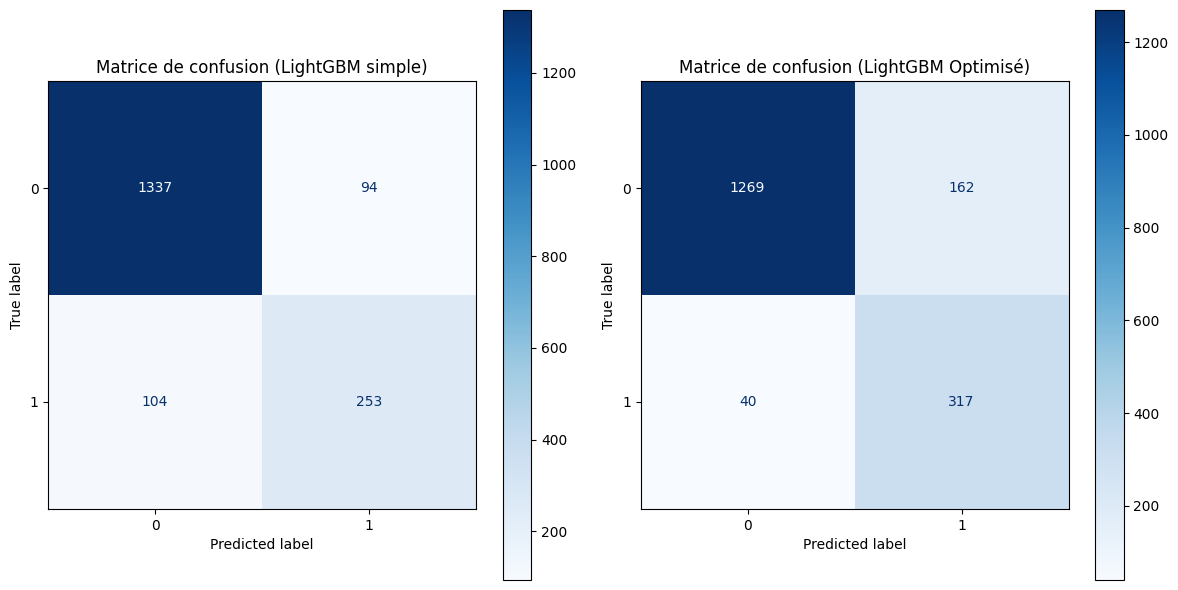

In [24]:
# Matrice de confusion pour le modèle LightGBM simple
cm_med = confusion_matrix(y_test, y_pred_med)
disp_med = ConfusionMatrixDisplay(confusion_matrix=cm_med)

# Matrice de confusion pour le modèle LightGBM optimisé
cm_opti= confusion_matrix(y_test, y_pred_final)
disp_opti = ConfusionMatrixDisplay(confusion_matrix=cm_opti)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

disp_med.plot(ax=axes[0], cmap='Blues')
axes[0].set_title("Matrice de confusion (LightGBM simple)")

disp_opti.plot(ax=axes[1], cmap='Blues')
axes[1].set_title("Matrice de confusion (LightGBM Optimisé)")

plt.tight_layout()
plt.show()

In [25]:
# Log-loss pour les données de test
logloss_test_med = log_loss(y_test, y_pred_med_probs)
logloss_test_med_opti = log_loss(y_test, y_pred_final_probs)

# Log-loss pour les données d'entraînement
y_train_med_probs = lgb_clf_med.predict(x_train_med)
y_train_opti_med_probs = lgb_clf_final.predict(x_train_med)

logloss_train_med = log_loss(y_train, y_train_med_probs)
log_loss_opti_med_train = log_loss(y_train, y_train_opti_med_probs)

print(f"Log-Loss (Train) pour le modèle LightGBM Optimisé : {log_loss_opti_med_train:.4f}")
print(f"Log-Loss (Test) pour le modèle LightGBM Optimisé: {logloss_test_med_opti:.4f}")

print(f"Log-Loss (Train) pour le modèle LightGBM simple : {logloss_train_med:.4f}")
print(f"Log-Loss (Test) pour le modèle LightGBM simple: {logloss_test_med:.4f}")

Log-Loss (Train) pour le modèle LightGBM Optimisé : 0.0449
Log-Loss (Test) pour le modèle LightGBM Optimisé: 0.2259
Log-Loss (Train) pour le modèle LightGBM simple : 0.2660
Log-Loss (Test) pour le modèle LightGBM simple: 0.3204


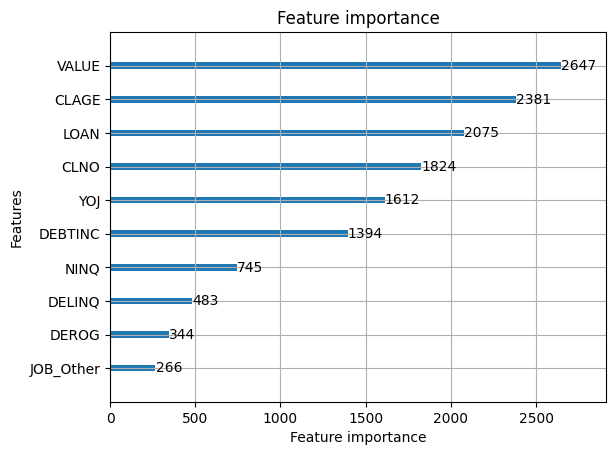

In [26]:
lgb.plot_importance(lgb_clf_final, max_num_features=10) 
plt.show()

# Valeurs de Shapley afin de décider des variables que l'on conserve

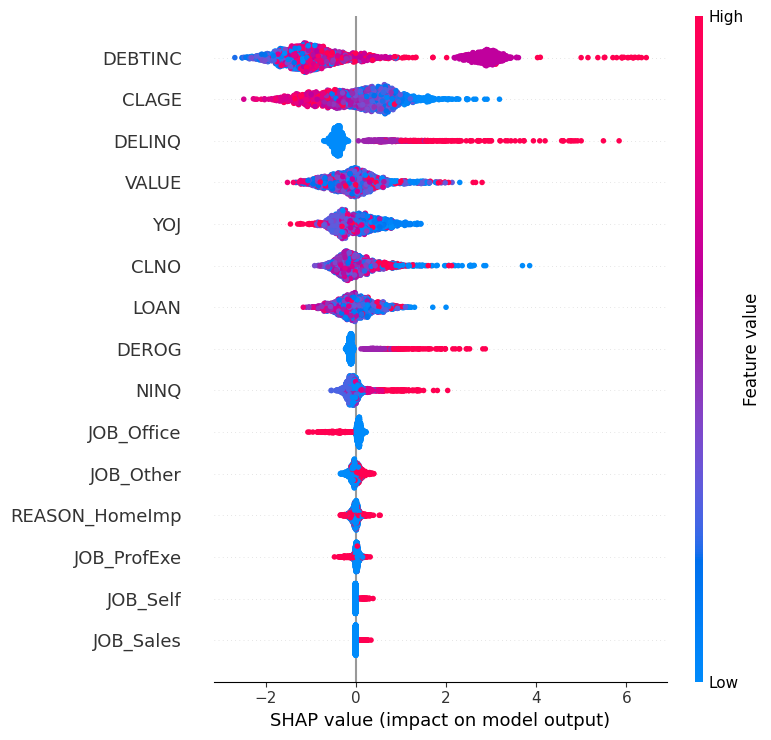

In [27]:
explainer = shap.TreeExplainer(lgb_clf_final)
shap_values = explainer(x_test_med)
shap.summary_plot(shap_values, x_test_med)

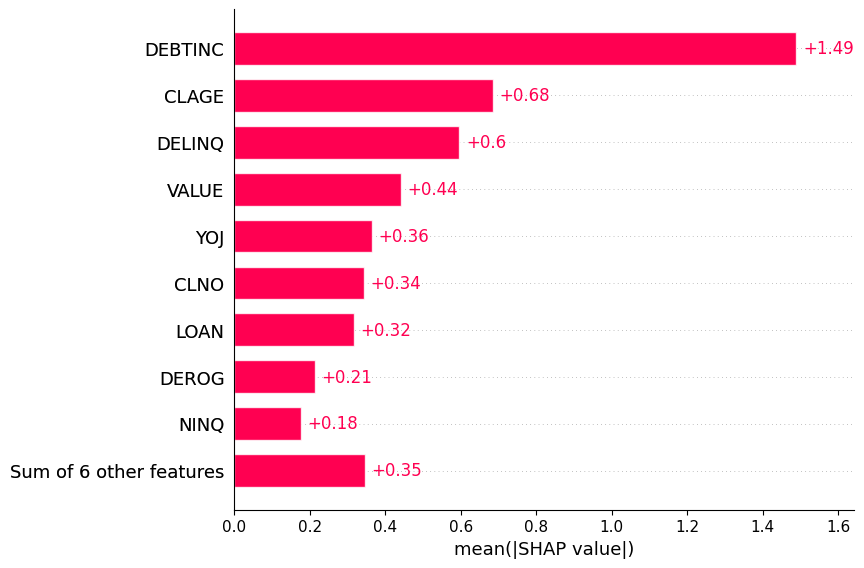

In [28]:
shap.plots.bar(shap_values) # Prends la valeur absolue de la moyenne des valeurs de Shapley sur l'ensemble de l'échantillon

In [31]:
# Liste de toutes les variables du modèle complet
colonnes = [
    'LOAN', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ',
    'CLNO', 'DEBTINC', 'JOB_Office', 'JOB_Other', 'JOB_ProfExe',
    'JOB_Sales', 'JOB_Self', 'REASON_HomeImp'
]

# On lance un modèle avec des paramètres aléatoires pour calculer l'évolution des performances en fonction du nombre de variables
def lancer_modele_aleatoire():
    precision_scores = []
    recall_scores = []
    f1_scores = []
    auc_scores = []
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting': 'gbdt',
        'is_unbalance': 'true',
        'max_depth': random.randint(1, 10),
        'num_leaves': random.randint(20, 100),  
        'learning_rate': random.uniform(0.01, 0.1),  
        'feature_fraction': random.uniform(0.5, 1.0),  
        'bagging_fraction': random.uniform(0.5, 1.0),  
        'bagging_freq': random.randint(1, 50), 
        'seed': random.randint(0, 1000),
        'verbose': -1
    }

    for i in range(1, len(colonnes) + 1):
        subset_columns = colonnes[:i]
        x_train_subset = x_train_med[subset_columns]
        x_test_subset = x_test_med[subset_columns]

        dtrain = lgb.Dataset(data=x_train_subset, label=y_train)
        dtest = lgb.Dataset(data=x_test_subset,label=y_test)

        # Train
        lgb_clf = lgb.train(params, dtrain, num_boost_round=2000, valid_sets=[dtest], 
                            callbacks=[lgb.early_stopping(stopping_rounds=50)] )

        # Prédictions 
        y_pred_probs = lgb_clf.predict(x_test_subset, num_iteration=lgb_clf.best_iteration)
        y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_probs]

        # Calcul des métriques
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_probs)

        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        auc_scores.append(auc)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(1, len(colonnes) + 1)), y=auc_scores, mode='lines+markers', 
                             marker=dict(size=10, color='red'), line=dict(color='red'), name='AUC'))
    fig.add_trace(go.Scatter(x=list(range(1, len(colonnes) + 1)), y=precision_scores, mode='lines+markers', 
                             marker=dict(size=10, color='green'), line=dict(color='green'), name='Precision'))
    fig.add_trace(go.Scatter(x=list(range(1, len(colonnes) + 1)), y=recall_scores, mode='lines+markers', 
                             marker=dict(size=10, color='orange'), line=dict(color='orange'), name='Recall'))
    fig.add_trace(go.Scatter(x=list(range(1, len(colonnes) + 1)), y=f1_scores, mode='lines+markers', 
                             marker=dict(size=10, color='blue'), line=dict(color='blue'), name='F1-Score'))
    fig.update_layout(
        title=f"Évolution des métriques (AUC, Precision, Recall, F1) - Paramètres: "
              f"max_depth={params['max_depth']}, learning_rate={round(params['learning_rate'], 2)}",
        title_x=0.5,
        xaxis_title="Nombre de variables",
        yaxis_title="Score",
        xaxis=dict(tickmode='linear'),
        template='plotly_white'
    )

    fig.show()

# On lance 5 modèles générés avec des paramètres aléatoires
for _ in range(5):
    lancer_modele_aleatoire()


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's auc: 0.653836
Training until validation scores don't improve for 50 rounds


/Users/issameabdeljalil/Desktop/M2_MOSEF/Scoring/Ma_Partie_Scoring/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Early stopping, best iteration is:
[118]	valid_0's auc: 0.687299
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[184]	valid_0's auc: 0.724725
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[155]	valid_0's auc: 0.787779
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[280]	valid_0's auc: 0.828448
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[290]	valid_0's auc: 0.870601
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[800]	valid_0's auc: 0.901515
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[648]	valid_0's auc: 0.927163
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[784]	valid_0's auc: 0.947526
Training until validation scores don't improve for 50

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[106]	valid_0's auc: 0.636111
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[491]	valid_0's auc: 0.669136
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[326]	valid_0's auc: 0.693053
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[474]	valid_0's auc: 0.742892
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[490]	valid_0's auc: 0.794631
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[295]	valid_0's auc: 0.803535
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[300]	valid_0's auc: 0.801809
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[296]	valid_0's auc: 0

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's auc: 0.657409
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's auc: 0.680092
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[219]	valid_0's auc: 0.729957
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[215]	valid_0's auc: 0.785329
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[242]	valid_0's auc: 0.820984
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[352]	valid_0's auc: 0.884529
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[906]	valid_0's auc: 0.906409
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[595]	valid_0's auc: 0.9

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[52]	valid_0's auc: 0.659154
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	valid_0's auc: 0.69178
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[223]	valid_0's auc: 0.727622
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[183]	valid_0's auc: 0.781689
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[239]	valid_0's auc: 0.821343
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[386]	valid_0's auc: 0.858342
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[503]	valid_0's auc: 0.873528
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[764]	valid_0's auc: 0.90

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[124]	valid_0's auc: 0.652904
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	valid_0's auc: 0.670251
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[331]	valid_0's auc: 0.723558
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[190]	valid_0's auc: 0.764319
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[240]	valid_0's auc: 0.8068
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[478]	valid_0's auc: 0.846793
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[484]	valid_0's auc: 0.853934
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[629]	valid_0's auc: 0.86

Suite à ces 5 graphiques générés sur des données aléatoires, ainsi qu'à l'interprétation des valeurs de Shapley on décide de conserver 8 variables afin d'optimiser davantage le modèle en supprimant les features peu utiles.

# Modèle simple avec un nombre de variables réduit LightGBM

In [32]:
# Voici les variables que l'on a décidé de conserver
best_col =  ['DEBTINC', 'CLAGE','DELINQ','VALUE','YOJ','CLNO','LOAN',"DEROG"]

x_train_med_reduced = data_train[best_col]
x_test_med_reduced = data_test[best_col]

data_lgb_train_med_reduced = lgb.Dataset(data=x_train_med_reduced,label=y_train)
data_lgb_test_med_reduced = lgb.Dataset(data=x_test_med_reduced,label=y_test)

In [33]:
# On commence par faire un modèle simple
params = {
            'objective':'binary', # On veut prédire une valeur binaire car on est dans un cas de classification binaire
            'metric': 'auc',
            'is_unbalance':'true', #On sait que nos données sont déséquilibrées entre 0 et 1, on utilise donc ce paramètre
            'boosting':'gbdt', # Gradient Boosting Decision Tree
            'num_leaves':64, #C'est la valeur par défaut
            'feature_fraction':0.5,# on sélectionne la moitié des variables, réduit l'overfitting
            'bagging_fraction':0.5,#Fraction d'échantillonnage
            'bagging_freq':20, #Fréquence du bagging
            'learning_rate': 0.01,
            'verbose':-1
        }

lgb_clf_med_reduced = lgb.train(params, data_lgb_train_med_reduced, valid_sets=data_lgb_test_med_reduced, num_boost_round=2000, callbacks=[
    lgb.early_stopping(stopping_rounds=50),
    ])

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[241]	valid_0's auc: 0.913835


In [34]:
y_pred_med_probs_reduced = lgb_clf_med_reduced.predict(x_test_med_reduced)
y_pred_med_reduced = [round(p) for p in y_pred_med_probs_reduced]

print(f"L'accuracy de notre modèle LightGBM simple réduit est : {round(accuracy_score(y_test, y_pred_med_reduced),2)}")

L'accuracy de notre modèle LightGBM simple réduit est : 0.88


In [35]:
cr_reduced=classification_report(y_test, y_pred_med_reduced)
print(f"\nTableau des métriques pour le modèle LightGBM simple Réduit : \n \n  {cr_reduced}")


Tableau des métriques pour le modèle LightGBM simple Réduit : 
 
                precision    recall  f1-score   support

           0       0.93      0.92      0.93      1431
           1       0.70      0.73      0.72       357

    accuracy                           0.88      1788
   macro avg       0.82      0.83      0.82      1788
weighted avg       0.89      0.88      0.89      1788



In [36]:
lr_auc_med_reduced = roc_auc_score(y_test, y_pred_med_probs_reduced)

print(f'Modèle Naïf: ROC AUC={round(ns_auc, 9):.6f}')
print(f'LightGBM | LightGBM Simple: ROC AUC={round(lr_auc_med, 9):.6f}')
print(f'LightGBM | LightGBM Simple et Réduit : ROC AUC={round(lr_auc_med_reduced, 9):.6f}')


# Calcul des courbes ROC
lr_fpr_med_reduced, lr_tpr_med_reduced, _ = roc_curve(y_test, y_pred_med_probs_reduced)

#Plot
fig = go.Figure()

fig.add_trace(go.Scatter(x=ns_fpr, y=ns_tpr, mode='lines',
                         name='Modèle Naïf',
                         line=dict(dash='dash', color='blue')))

fig.add_trace(go.Scatter(x=lr_fpr_med, y=lr_tpr_med, mode='lines+markers',
                         name='LightGBM | Modèle Simple',
                         marker=dict(symbol='circle', color='green')))

fig.add_trace(go.Scatter(x=lr_fpr_med_reduced, y=lr_tpr_med_reduced, mode='lines+markers',
                         name='LightGBM | Modèle Simple Réduit',
                         marker=dict(symbol='circle', color='violet')))

fig.update_layout(
    title="Courbe ROC",
    xaxis_title="Taux de Faux Positifs (FPR)",
    yaxis_title="Taux de Vrais Positifs (TPR)",
    legend_title="Modèles",
    template="plotly_white"
)
fig.show()

Modèle Naïf: ROC AUC=0.500000
LightGBM | LightGBM Simple: ROC AUC=0.924315
LightGBM | LightGBM Simple et Réduit : ROC AUC=0.913835


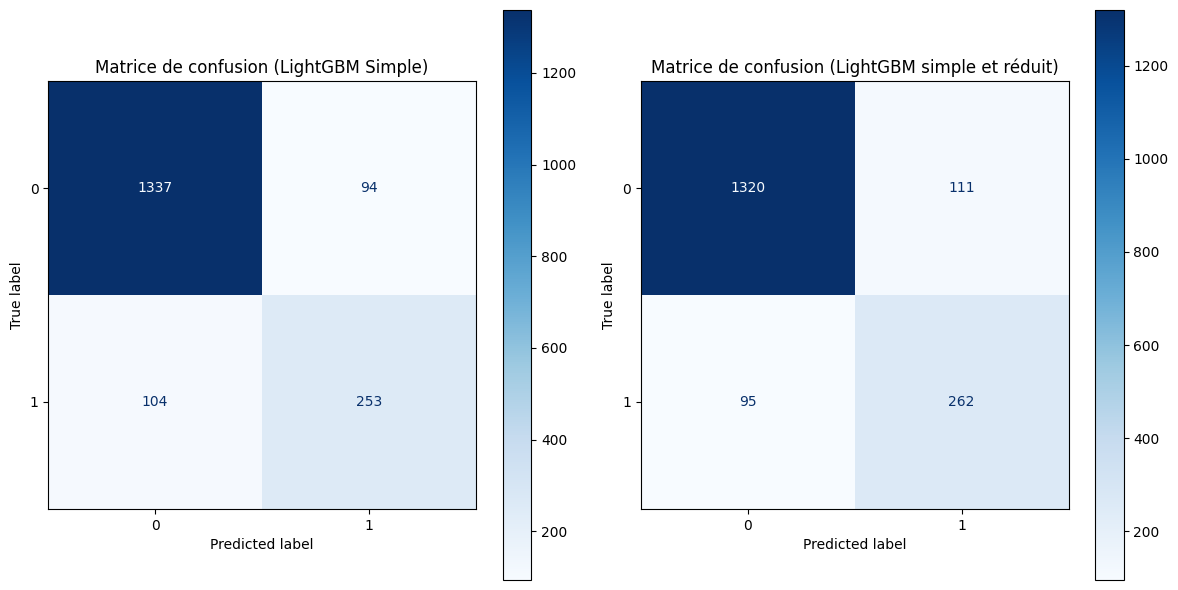

In [37]:
# Matrice de confusion pour le modèle LightGBM simple
cm_med = confusion_matrix(y_test, y_pred_med)
disp_med = ConfusionMatrixDisplay(confusion_matrix=cm_med)

# Matrice de confusion pour le modèle LightGBM simple et réduit
cm_rd_med = confusion_matrix(y_test, y_pred_med_reduced)
disp_rd_med = ConfusionMatrixDisplay(confusion_matrix=cm_rd_med)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

disp_med.plot(ax=axes[0], cmap='Blues')
axes[0].set_title("Matrice de confusion (LightGBM Simple)")

disp_rd_med.plot(ax=axes[1], cmap='Blues')
axes[1].set_title("Matrice de confusion (LightGBM simple et réduit)")

plt.tight_layout()
plt.show()

In [38]:
# Log-loss pour le Test
logloss_test_med = log_loss(y_test, y_pred_med_probs)
logloss_test_med_reduced = log_loss(y_test, y_pred_med_probs_reduced)

# Log-loss pour le Train
y_train_med_probs = lgb_clf_med.predict(x_train_med)
y_train_med_probs_reduced = lgb_clf_med_reduced.predict(x_train_med_reduced)

logloss_train_med = log_loss(y_train, y_train_med_probs)
log_loss_med_train_reduced = log_loss(y_train, y_train_med_probs_reduced)

print(f"Log-Loss (Train) pour le modèle LightGBM simple Réduit : {log_loss_med_train_reduced:.4f}")
print(f"Log-Loss (Test) pour le modèle LightGBM simple Réduit: {logloss_test_med_reduced:.4f}")

print(f"Log-Loss (Train) pour le modèle LightGBM simple: {logloss_train_med:.4f}")
print(f"Log-Loss (Test) pour le modèle LightGBM simple: {logloss_test_med:.4f}")

Log-Loss (Train) pour le modèle LightGBM simple Réduit : 0.2491
Log-Loss (Test) pour le modèle LightGBM simple Réduit: 0.3176
Log-Loss (Train) pour le modèle LightGBM simple: 0.2660
Log-Loss (Test) pour le modèle LightGBM simple: 0.3204


# Optimisation du modèle LightGBM simple réduit à l'aide d'Optuna

In [39]:
def objective_reduced(trial):
    # Optimisation des paramètres pour le modèle LightGBM simple et réduit
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'is_unbalance': 'true',  # Gestion du déséquilibre des classes
        'boosting': 'gbdt',      # Gradient Boosting Decision Tree
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),  # Optimisation de num_leaves
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),  # Optimisation de feature_fraction
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),  # Optimisation de bagging_fraction
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 50),  # Optimisation de bagging_freq
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),  # Optimisation du learning rate
        'verbose': -1
    }

    # Validation croisée
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    auc_scores = []

    for train_idx, valid_idx in skf.split(x_train_med_reduced, y_train):
        X_train, X_valid = x_train_med_reduced.iloc[train_idx], x_train_med_reduced.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        dtrain = lgb.Dataset(X_train, label=y_train_fold)
        dvalid = lgb.Dataset(X_valid, label=y_valid_fold, reference=dtrain)

        # Train
        lgb_clf_med_reduced = lgb.train(params, dtrain, valid_sets=[dvalid], num_boost_round=2000, callbacks=[
            lgb.early_stopping(stopping_rounds=50),
        ])

        # Prédictions sur le jeu de validation
        y_pred_med_probs_reduced = lgb_clf_med_reduced.predict(X_valid, num_iteration=lgb_clf_med_reduced.best_iteration)

        # AUC
        auc = roc_auc_score(y_valid_fold, y_pred_med_probs_reduced)
        auc_scores.append(auc)

    # On récupère la moyenne des AUC pour tous les splits du StratifiedKfold
    return np.mean(auc_scores)


In [40]:
#Optimisation avec Optuna
optuna.logging.disable_default_handler()
study_opti_reduced = optuna.create_study(direction='maximize')
study_opti_reduced.optimize(objective_reduced, n_trials=100)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[119]	valid_0's auc: 0.928735
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[160]	valid_0's auc: 0.951365
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[279]	valid_0's auc: 0.953809
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[380]	valid_0's auc: 0.955856
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[552]	valid_0's auc: 0.95059
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[270]	valid_0's auc: 0.929578
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[116]	valid_0's auc: 0.949273
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[252]	valid_0's auc: 0.

In [41]:
# Meilleurs paramètres trouvés
best_params_reduced = study_opti_reduced.best_params
print("Best parameters:", best_params_reduced)

Best parameters: {'num_leaves': 107, 'feature_fraction': 0.8206502241334996, 'bagging_fraction': 0.716544242268378, 'bagging_freq': 11, 'learning_rate': 0.06764295963049213}


In [42]:
fixed_params = {
    'objective': 'binary',  # On veut prédire une valeur binaire
    'is_unbalance': 'true',  # On veut gérer les classes déséquilibrées
    'boosting': 'gbdt',  
}

final_params_reduced = {**best_params_reduced, **fixed_params}
final_params_reduced

{'num_leaves': 107,
 'feature_fraction': 0.8206502241334996,
 'bagging_fraction': 0.716544242268378,
 'bagging_freq': 11,
 'learning_rate': 0.06764295963049213,
 'objective': 'binary',
 'is_unbalance': 'true',
 'boosting': 'gbdt'}

In [43]:
optuna.visualization.plot_optimization_history(study_opti_reduced) #On voit que plus on augmente le nombre de trial, meilleure sera la valeur de l'AUC. Cela reste marginal après le trial 26.

In [44]:
lgb_clf_final_reduced = lgb.train(final_params_reduced, lgb.Dataset(x_train_med_reduced, label=y_train), valid_sets=[lgb.Dataset(x_test_med_reduced, label=y_test)], num_boost_round=2000, callbacks=[
    lgb.early_stopping(stopping_rounds=50),
])

y_pred_final_probs_reduced = lgb_clf_final_reduced.predict(x_test_med_reduced)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[104]	valid_0's binary_logloss: 0.245437


In [45]:
# Scores AUC
lr_auc_opti_med_reduced = roc_auc_score(y_test, y_pred_final_probs_reduced)

print(f'Modèle Naïf: ROC AUC = {round(ns_auc, 2)}')
print(f'LightGBM | LightGBM Optimisé: ROC AUC = {round(lr_auc_opti_med, 2)}')
print(f'LightGBM | LightGBM Optimisé et réduit: ROC AUC = {round(lr_auc_opti_med_reduced, 2)}')

lr_fpr_opti_reduced, lr_tpr_opti_reduced, thresholds = roc_curve(y_test, y_pred_final_probs_reduced)

# On sélectionne le seuil optimal
tpr_fpr_diff = lr_tpr_opti_reduced - lr_fpr_opti_reduced
best_idx = np.argmax(tpr_fpr_diff)
best_threshold_opti_reduced = thresholds[best_idx]
best_tpr = lr_tpr_opti_reduced[best_idx]
best_fpr = lr_fpr_opti_reduced[best_idx]

fig = go.Figure()

fig.add_trace(go.Scatter(x=ns_fpr, y=ns_tpr, mode='lines',
                         name='Modèle Naïf',
                         line=dict(dash='dash', color='blue')))

fig.add_trace(go.Scatter(x=lr_fpr_opti_med, y=lr_tpr_opti_med, mode='lines+markers',
                         name='LightGBM | LightGBM Optimisé',
                         marker=dict(symbol='circle', size=3, color='green')))
fig.add_trace(go.Scatter(x=lr_fpr_opti_reduced, y=lr_tpr_opti_reduced, mode='lines+markers',
                         name='LightGBM | LightGBM Optimisé et Réduit',
                         marker=dict(symbol='circle', size=3, color='black')))

# Seuil optimal
fig.add_trace(go.Scatter(
    x=[best_fpr],
    y=[best_tpr],
    mode='markers',
    name=f'Seuil optimal : {best_threshold_opti_reduced:.2f}',
    marker=dict(color='red', size=10)
))

fig.update_layout(
    title="Courbe ROC",
    xaxis_title="Taux de Faux Positifs (FPR)",
    yaxis_title="Taux de Vrais Positifs (TPR)",
    legend_title="Modèles",
    template="plotly_white",
    width=1000,  
    height=600,  
)

fig.show()


Modèle Naïf: ROC AUC = 0.5
LightGBM | LightGBM Optimisé: ROC AUC = 0.95
LightGBM | LightGBM Optimisé et réduit: ROC AUC = 0.94


In [46]:
threshold_opti = best_threshold_opti_reduced  # Seuil optimal qu'on a calculé grâce au FPR et TPR
y_pred_med_opti_reduced = (y_pred_final_probs_reduced >= threshold_opti).astype(int)

cr_opti_reduced=classification_report(y_test, y_pred_med_opti_reduced)
print(f"\nTableau des métriques pour le modèle LightGBM Optimisé et Réduit: \n \n  {cr_opti_reduced}")


Tableau des métriques pour le modèle LightGBM Optimisé et Réduit: 
 
                precision    recall  f1-score   support

           0       0.97      0.86      0.91      1431
           1       0.61      0.90      0.73       357

    accuracy                           0.87      1788
   macro avg       0.79      0.88      0.82      1788
weighted avg       0.90      0.87      0.87      1788



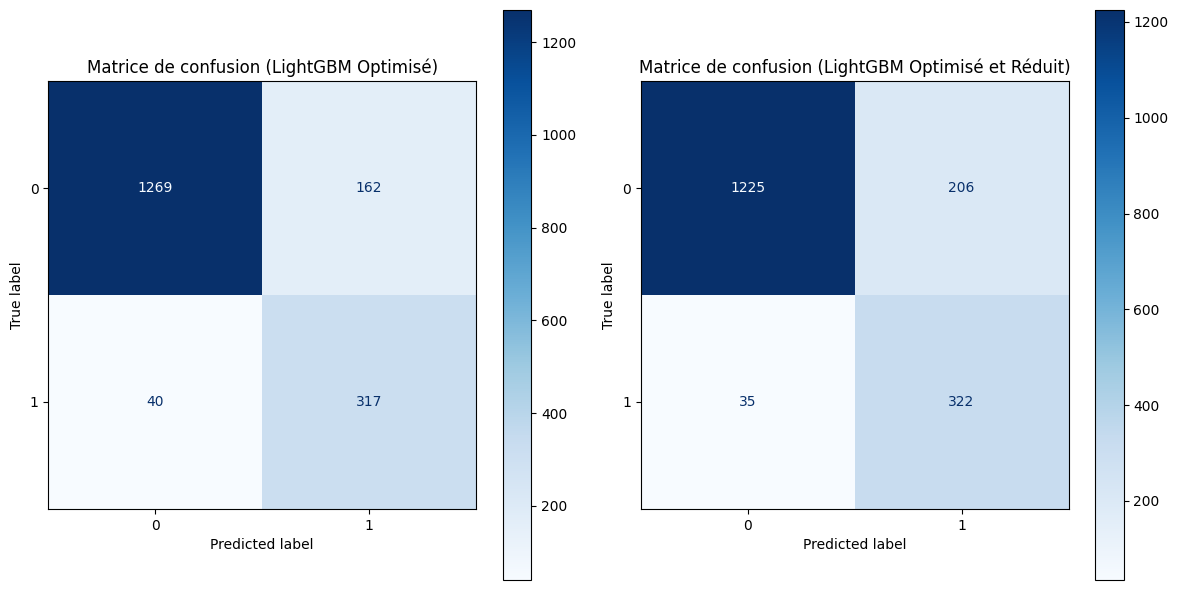

In [47]:
# Matrice de confusion pour le modèle LightGBM Optimisé
cm_med = confusion_matrix(y_test, y_pred_final)
disp_med = ConfusionMatrixDisplay(confusion_matrix=cm_med)

# Matrice de confusion pour le modèle LightGBM Optimisé et Réduit 
cm_rd_med = confusion_matrix(y_test, y_pred_med_opti_reduced)
disp_rd_med = ConfusionMatrixDisplay(confusion_matrix=cm_rd_med)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

disp_med.plot(ax=axes[0], cmap='Blues')
axes[0].set_title("Matrice de confusion (LightGBM Optimisé)")

disp_rd_med.plot(ax=axes[1], cmap='Blues')
axes[1].set_title("Matrice de confusion (LightGBM Optimisé et Réduit)")

plt.tight_layout()
plt.show()

In [48]:
# Log-loss pour les données de test
logloss_test_med_opti_reduced = log_loss(y_test, y_pred_final_probs_reduced)
logloss_test_med_opti = log_loss(y_test, y_pred_final_probs)

# Log-loss pour les données d'entraînement
y_train_med_probs_opti_reduced = lgb_clf_final_reduced.predict(x_train_med_reduced)
y_train_opti_med_probs = lgb_clf_final.predict(x_train_med)

logloss_train_med_opti_reduced = log_loss(y_train, y_train_med_probs_opti_reduced)
log_loss_opti_med_train = log_loss(y_train, y_train_opti_med_probs)

print(f"Log-Loss (Train) pour le modèle LightGBM Optimisé : {log_loss_opti_med_train:.4f}")
print(f"Log-Loss (Test) pour le modèle LightGBM Optimisé: {logloss_test_med_opti:.4f}")

print(f"Log-Loss (Train) pour le modèle LightGBM Optimisé et réduit: {logloss_train_med_opti_reduced:.4f}")
print(f"Log-Loss (Test) pour le modèle LightGBM Optimisé et réduit : {logloss_test_med_opti_reduced:.4f}")

Log-Loss (Train) pour le modèle LightGBM Optimisé : 0.0449
Log-Loss (Test) pour le modèle LightGBM Optimisé: 0.2259
Log-Loss (Train) pour le modèle LightGBM Optimisé et réduit: 0.0459
Log-Loss (Test) pour le modèle LightGBM Optimisé et réduit : 0.2454


Comparaison des métriques en fonction des différents modèles sélectionnés

In [49]:
# Modèle Données Brutes
precision_raw = precision_score(y_test, y_pred_raw)
recall_raw = recall_score(y_test, y_pred_raw)
f1_raw = f1_score(y_test, y_pred_raw)
gini_raw = 2 * lr_auc_raw - 1

# Modèle LightGBM Optimisé
precision_opti = precision_score(y_test, y_pred_final)
recall_opti = recall_score(y_test, y_pred_final)
f1_opti = f1_score(y_test, y_pred_final)
gini_opti = 2 * lr_auc_opti_med - 1

# Modèle LightGBM Optimisé et Réduit
precision_opti_reduced = precision_score(y_test, y_pred_med_opti_reduced)
recall_opti_reduced = recall_score(y_test, y_pred_med_opti_reduced)
f1_opti_reduced = f1_score(y_test, y_pred_med_opti_reduced)
gini_opti_reduced = 2 * lr_auc_opti_med_reduced - 1

# Liste des métriques pour chacun de nos modèles construit
metrics = ['Précision', 'Recall', 'F1-Score', 'Indice de Gini']
values_raw = [precision_raw, recall_raw, f1_raw, gini_raw]
values_opti = [precision_opti, recall_opti, f1_opti, gini_opti]
values_opti_reduced = [precision_opti_reduced, recall_opti_reduced, f1_opti_reduced, gini_opti_reduced]


fig = go.Figure()

fig.add_trace(go.Bar(
    x=metrics,
    y=values_raw,
    name='Modèle Données Brutes',
    marker_color='#FF5733',
    text=[f"{v:.2f}" for v in values_raw], 
    textposition='inside' 
))
fig.add_trace(go.Bar(
    x=metrics,
    y=values_opti,
    name='Modèle Optimisé',
    marker_color='#33C3FF', 
    text=[f"{v:.2f}" for v in values_opti],
    textposition='inside'
))
fig.add_trace(go.Bar(
    x=metrics,
    y=values_opti_reduced,
    name='Modèle Optimisé et Réduit',
    marker_color='#50C878', 
    text=[f"{v:.2f}" for v in values_opti_reduced],
    textposition='inside'
))

fig.update_layout(
    title="Comparaison des métriques entre différents modèles",
    xaxis_title="Métriques",
    yaxis_title="Valeurs",
    barmode='group',
    legend=dict(
        title="Modèles",
        x=1.05, 
        y=1,
        orientation="v"  
    ),
    plot_bgcolor='rgba(245, 245, 245, 1)', 
    font=dict(
        family="Arial",
        size=14,
        color="black"
    )
)

fig.show()
